# Compare global runoff climatology to time-varying

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys
import glob
import os

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import boto3

In [2]:
# open grid file
ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r5/grid/nctiles_grid/ECCO-GRID.nc')

In [3]:
# define directory to runoff file
runoff_dir = '/efs_ecco/mzahn/r5/input/input_forcing/other/'
fname = 'runoff-2d-Fekete-1deg-mon-V4-SMOOTH_S60scalving_v3.bin'

In [4]:
runoff = ecco.read_llc_to_tiles(runoff_dir, fname, nl=12)

load_binary_array: loading file /efs_ecco/mzahn/r5/input/input_forcing/other/runoff-2d-Fekete-1deg-mon-V4-SMOOTH_S60scalving_v3.bin
load_binary_array: data array shape  (12, 1, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (12, 1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (12, 1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
# specify that the 5th dimension should be time
runoff_da = ecco.llc_tiles_to_xda(runoff, var_type='c',dim4='depth', dim5='time')
# runoff_da

In [6]:
# mask out land
runoff_masked = runoff_da.where(ecco_grid.hFacC)

In [7]:
# runoff in cubic meters per second
runoff_m3pers = runoff_masked * ecco_grid.rA

Runoff


<Figure size 1400x600 with 0 Axes>

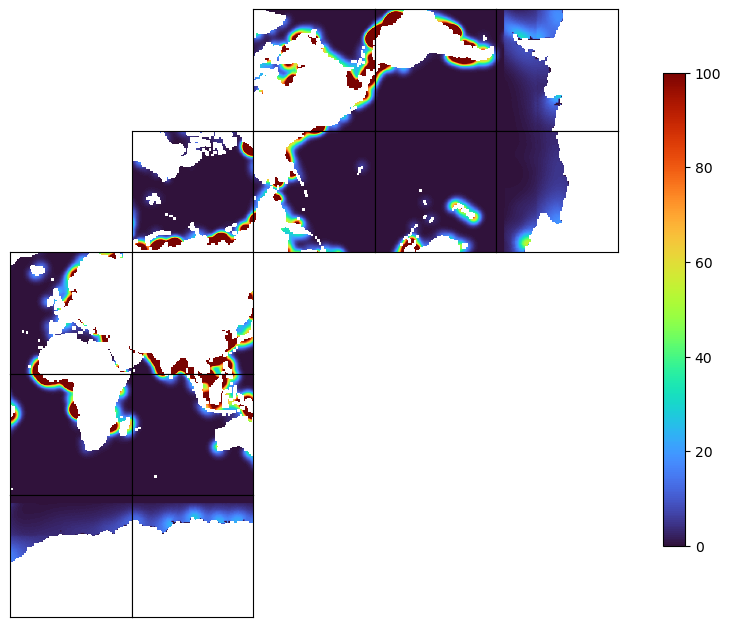

In [8]:
plt.figure(figsize=[14,6]);

ecco.plot_tiles(runoff_m3pers.isel(k=0,time=6), show_colorbar=True, 
                cmin=0, cmax=100, 
                cmap='turbo', 
                rotate_to_latlon=True,
               show_tile_labels=False);

print(f'Runoff');

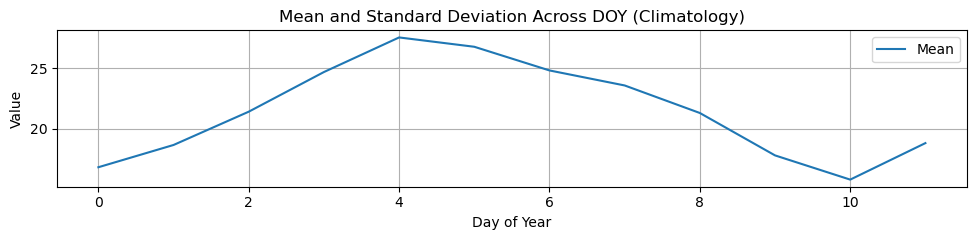

In [9]:
# Compute climatology: mean and std across years for each DOY
mean_clim = runoff_m3pers.mean(dim=['i','j','tile']).isel(k=0)
std_clim = runoff_m3pers.std(dim=['i','j','tile']).isel(k=0)

# Plot
plt.figure(figsize=(10, 2.5))
mean_clim.plot(label="Mean", color="tab:blue")
# plt.fill_between(mean_clim["time"], mean_clim - std_clim, mean_clim + std_clim, color="tab:blue", alpha=0.3, label="±1 Std Dev")
plt.xlabel("Day of Year")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Across DOY (Climatology)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot time-varying runoff

In [11]:
# define directory to runoff file
runoff_dir = '/efs_ecco/mzahn/freshwater_runoff/'
fname = 'jra55_do_runoff_ECCO_V4r5_1991'

In [12]:
runoff_daily = ecco.read_llc_to_tiles(runoff_dir, fname, nl=365)
# specify that the 5th dimension should be time
runoff_daily = ecco.llc_tiles_to_xda(runoff, var_type='c',dim4='depth', dim5='time')
# runoff_daily

load_binary_array: loading file /efs_ecco/mzahn/freshwater_runoff/jra55_do_runoff_ECCO_V4r5_1991
load_binary_array: data array shape  (365, 1, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (365, 1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (365, 1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [13]:
# Directory with runoff files
runoff_dir = '/efs_ecco/mzahn/freshwater_runoff/'

# Use glob to find all files matching pattern in runoff_dir
# Adjust the pattern as needed to match your filenames, e.g., all years starting with 'jra55_do_runoff_ECCO_V4r5_'
file_pattern = os.path.join(runoff_dir, 'jra55_do_runoff_ECCO_V4r5_*')
file_list = sorted(glob.glob(file_pattern))

datasets = []

for filepath in file_list:
    # Extract the filename without extension to pass to read_llc_to_tiles
    fname = os.path.basename(filepath)
    
    # Read the runoff data using ECCO functions
    runoff = ecco.read_llc_to_tiles(runoff_dir, fname, nl=365,less_output = True)
    
    # Convert tiles to xarray DataArray, specify time as 5th dimension
    runoff_daily = ecco.llc_tiles_to_xda(runoff, var_type='c', dim4='depth', dim5='time')
    
    # Assign a year coordinate from filename (assuming year is in the filename, e.g., last 4 digits)
    # Adjust this parsing to fit your actual filename structure
    year_str = fname.split('_')[-1]
    try:
        year = int(year_str)
    except ValueError:
        year = None
    
    if year is not None:
        runoff_daily = runoff_daily.expand_dims({'year':[year]})
    
    datasets.append(runoff_daily)

# Concatenate all yearly datasets along the 'year' dimension
runoff_all_years = xr.concat(datasets, dim='year')

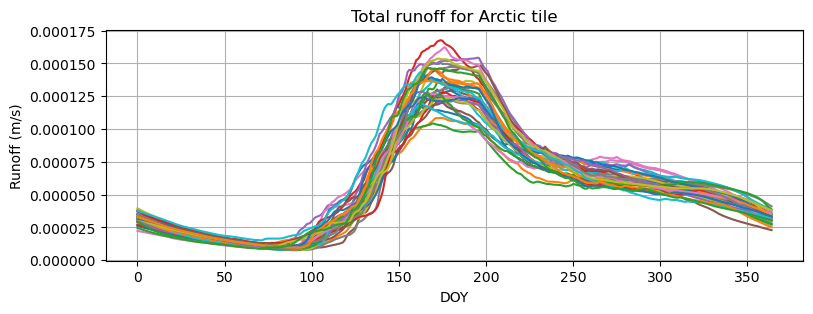

In [13]:
runoff_all_years.isel(tile=6,k=0).sum(dim=['i','j']).plot(hue='year',add_legend=False,figsize=[9, 3]);
# labels
plt.grid()
plt.xlabel('DOY')
plt.title("Total runoff for Arctic tile")
plt.ylabel("Runoff (m/s)");
# plt.tight_layout()

In [14]:
# mask out land
runoff_daily_masked = runoff_all_years.where(ecco_grid.hFacC)

In [15]:
# runoff in cubic meters per second
runoff_daily_m3pers = runoff_daily_masked * ecco_grid.rA

Runoff


<Figure size 1400x600 with 0 Axes>

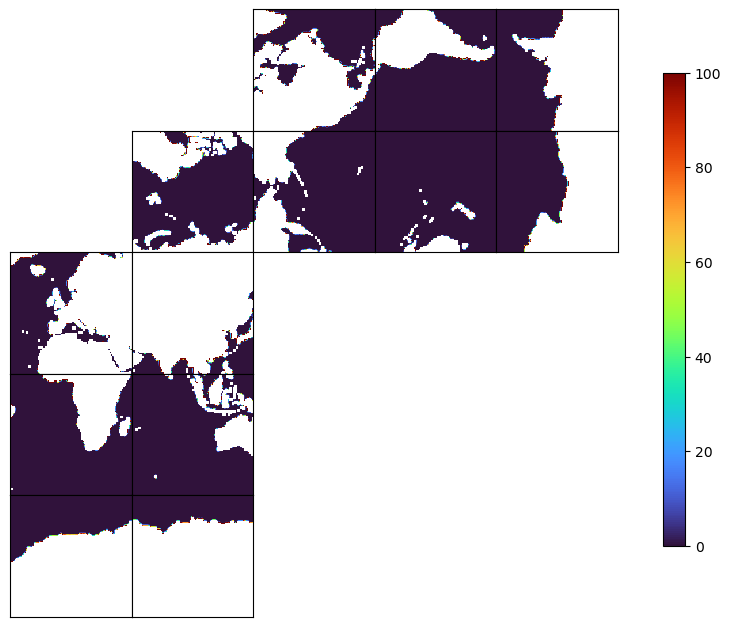

In [16]:
plt.figure(figsize=[14,6]);

ecco.plot_tiles(runoff_daily_m3pers.isel(k=0,year=6,time=200), show_colorbar=True, 
                cmin=0, cmax=100, 
                cmap='turbo', 
                rotate_to_latlon=True,
               show_tile_labels=False);

print(f'Runoff');

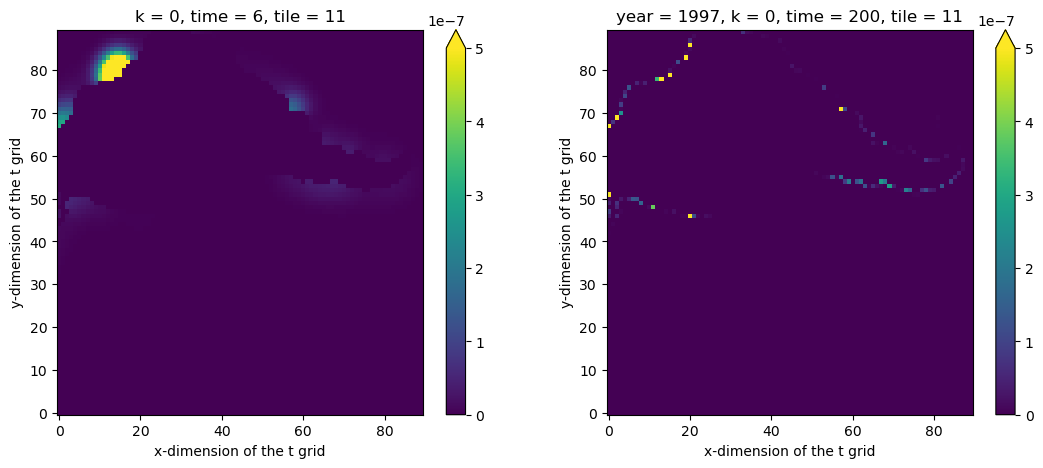

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13,5])
runoff_da.isel(k=0,time=6,tile=11).plot(ax=ax1,vmin=0,vmax=5e-7);
runoff_all_years.isel(k=0,year=6,time=200,tile=11).plot(ax=ax2,vmin=0,vmax=5e-7);

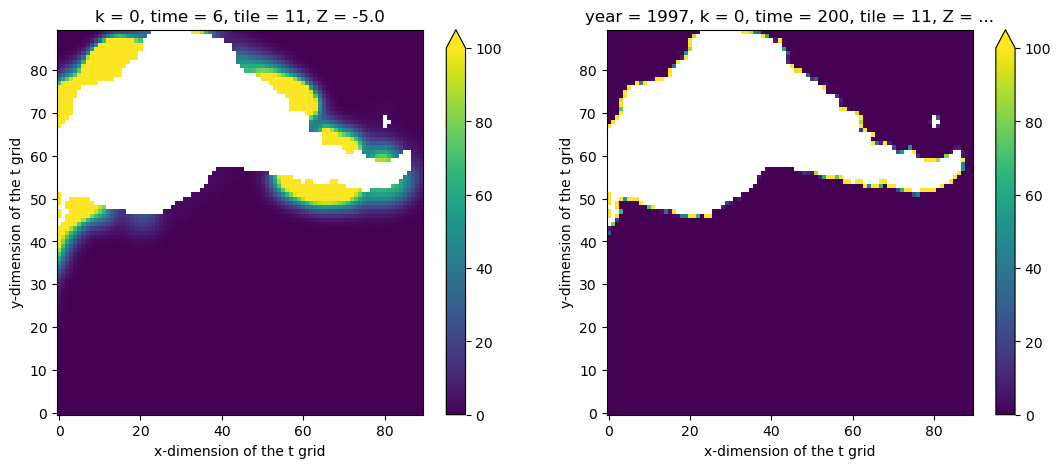

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13,5])
runoff_m3pers.isel(k=0,time=6,tile=11).plot(ax=ax1,vmin=0,vmax=100);
runoff_daily_m3pers.isel(k=0,year=6,time=200,tile=11).plot(ax=ax2,vmin=0,vmax=100);

In [16]:
# mask out grid cells = 0
runoff_m3pers_filter = runoff_m3pers.where(runoff_m3pers>0.5)
runoff_daily_m3pers_filter = runoff_daily_m3pers.where(runoff_daily_m3pers>0.5)

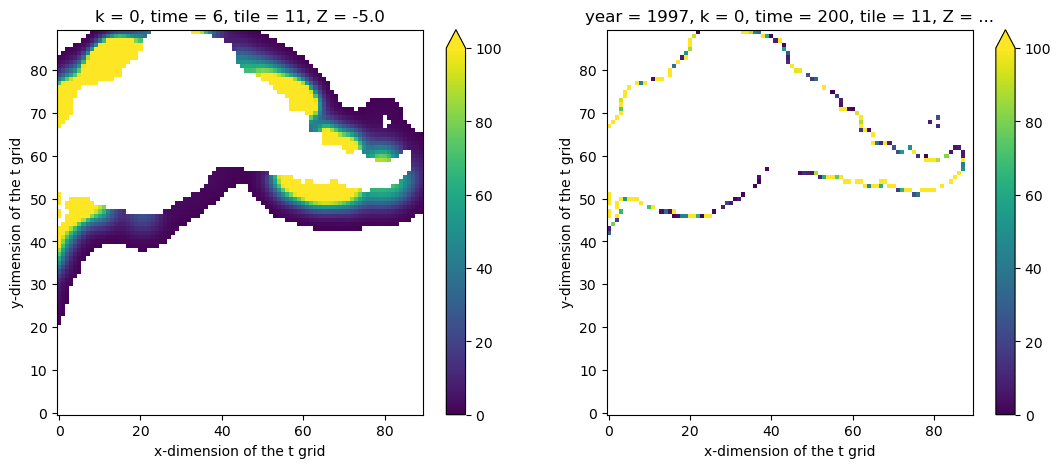

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13,5])
runoff_m3pers_filter.isel(k=0,time=6,tile=11).plot(ax=ax1,vmin=0,vmax=100);
runoff_daily_m3pers_filter.isel(k=0,year=6,time=200,tile=11).plot(ax=ax2,vmin=0,vmax=100);

In [21]:
# Compute mean for time-varying runoff
mean_daily = runoff_daily_m3pers.mean(dim=['year','i','j','tile']).isel(k=0)
std_daily = runoff_daily_m3pers.std(dim=['year','i','j','tile']).isel(k=0)

# mean_daily = runoff_daily_m3pers_filter.mean(dim=['year','i','j','tile']).isel(k=0)
# std_daily = runoff_daily_m3pers_filter.std(dim=['year','i','j','tile']).isel(k=0)

In [22]:
# Compute mean for climatology
mean_clim = runoff_m3pers.mean(dim=['i','j','tile']).isel(k=0)
std_clim = runoff_m3pers.std(dim=['i','j','tile']).isel(k=0)

# mean_clim = runoff_m3pers_filter.mean(dim=['i','j','tile']).isel(k=0)
# std_clim = runoff_m3pers_filter.std(dim=['i','j','tile']).isel(k=0)

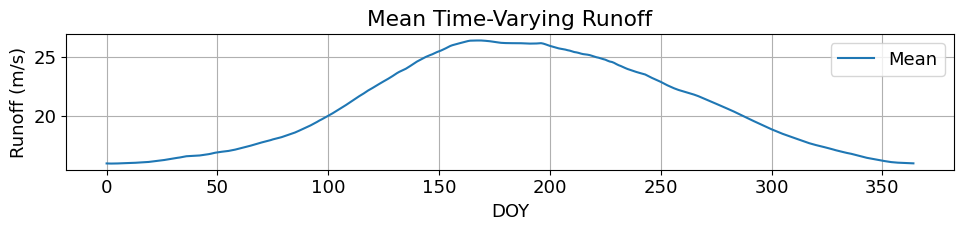

In [23]:
# Plot
plt.figure(figsize=(10, 2.5))
mean_daily.plot(label="Mean", color="tab:blue")
# plt.fill_between(mean_daily["time"], mean_daily - std_daily, mean_daily + std_daily, color="tab:blue", alpha=0.3, label="Std Dev")
plt.xlabel("DOY")
plt.ylabel("Runoff (m/s)")
plt.title("Mean Time-Varying Runoff")
# plt.ylim(2.5e-9,8e-9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

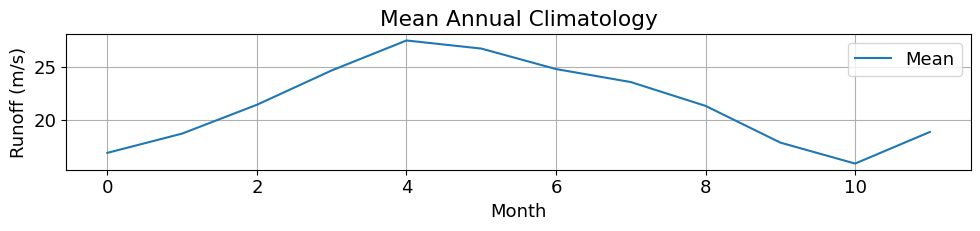

In [24]:
# Plot
plt.figure(figsize=(10, 2.5))
mean_clim.plot(label="Mean", color="tab:blue")
# plt.fill_between(mean_clim["time"], mean_clim - std_clim, mean_clim + std_clim, color="tab:blue", alpha=0.3, label="Std Dev")
plt.xlabel("Month")
plt.ylabel("Runoff (m/s)")
plt.title("Mean Annual Climatology")
# plt.ylim(2.5e-9,8e-9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# reindex month for climatology
mean_clim['time'] = mean_clim['time'] + 1

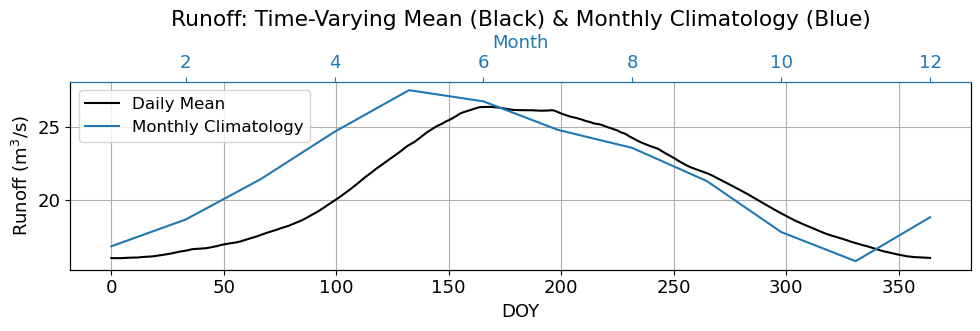

In [33]:
plt.rcParams['font.size'] = 13
fig, ax1 = plt.subplots(figsize=(10, 3.5))

# === Primary X-axis (Bottom): DOY ===
line1 = ax1.plot(mean_daily['time'], mean_daily, label="Daily Mean", color='black')
ax1.set_xlabel("DOY", color='black')
ax1.set_ylabel("Runoff (m$^3$/s)")
# ax1.set_ylim(2.5e-9, 8e-9)
ax1.tick_params(axis='x', colors='black')
ax1.grid(True)

# === Secondary X-axis (Top): Monthly Climatology ===
ax2 = ax1.twiny()
line2 = ax2.plot(mean_clim['time'], mean_clim, label="Monthly Climatology", color='tab:blue')
ax2.set_xlabel("Month", color='tab:blue')
ax2.tick_params(axis='x', colors='tab:blue')
ax2.spines['top'].set_color('tab:blue')

# === Legends (combined from both axes) ===
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left',fontsize=12)

# === Titles & Layout ===
plt.title("Runoff: Time-Varying Mean (Black) & Monthly Climatology (Blue)")
plt.tight_layout()
plt.show()

## Compute sum of global runoff

In [35]:
# since we have 33 years, take monthly mean across all years and then sum it up
runoff_daily_m3pers_mean = runoff_daily_m3pers.mean(dim='year')

In [36]:
years = runoff_daily_m3pers.coords['year'].values
doys = runoff_daily_m3pers.coords['time'].values

# Create all combinations of (year, doy)
year_grid, doy_grid = np.meshgrid(years, doys, indexing='ij')  # shape (33, 365)

# Convert (year, doy) into datetime objects
flat_datetimes = [pd.Timestamp(f"{y}-01-01") + pd.Timedelta(days=int(d)-1)
                  for y, d in zip(year_grid.ravel(), doy_grid.ravel())]

# Reshape back to (year, time) and assign to DataArray
datetimes = np.array(flat_datetimes).reshape(year_grid.shape)
runoff_daily_m3pers_da = runoff_daily_m3pers.assign_coords(datetime=(("year", "time"), datetimes))

# Group by month and average across year and time
runoff_daily_m3pers_mon_mean = runoff_daily_m3pers_da.groupby('datetime.month').mean(dim=["year", "time"])

In [37]:
# Integrated sum across tile, i, j
runoff_daily_m3pers_sum = runoff_daily_m3pers_mon_mean.isel(k=0).sum(dim=['i','j','tile'])

In [38]:
# Integrated sum across tile, i, j
runoff_m3pers_sum = runoff_m3pers.sum(dim=['i','j','tile'])

In [41]:
# reindex month
runoff_m3pers_sum['time'] = runoff_m3pers_sum['time'] + 1

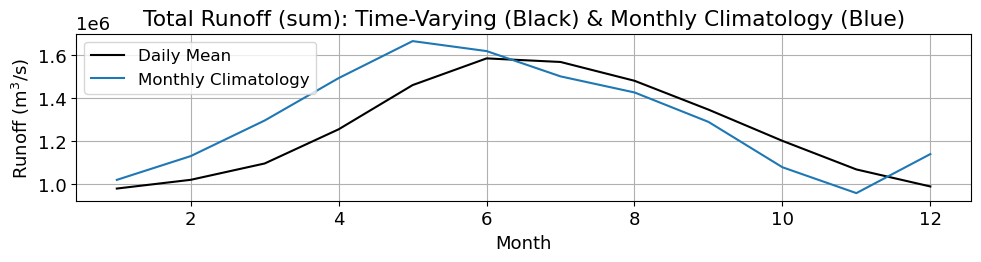

In [42]:
plt.rcParams['font.size'] = 13
fig, ax1 = plt.subplots(figsize=(10, 3))

runoff_daily_m3pers_sum.plot(ax=ax1, label="Daily Mean", color='black')
runoff_m3pers_sum.plot(ax=ax1, label="Monthly Climatology", color='tab:blue')

ax1.legend(loc='upper left',fontsize=12)

ax1.set_xlabel("Month", color='black')
ax1.set_ylabel("Runoff (m$^3$/s)")
# ax1.set_ylim(2.5e-9, 8e-9)
ax1.tick_params(axis='x', colors='black')
ax1.grid(True)

plt.title("Total Runoff (sum): Time-Varying (Black) & Monthly Climatology (Blue)")
plt.tight_layout()
plt.show()